# Vector ARIMA Model for AQI and Concentration Prediction of Pollutants

In our study, we evaluated the performance of a vector ARMA model against the enhanced CART model. For this comparison, we used the last 120 data points, equivalent to five days, as our validation set. We fine-tuned the ARMA model by adjusting the parameters p and q to minimize the root mean square error (RMSE). Initially, the ARMA model showed promising results, accurately capturing the trend in the first 60 samples of the validation dataset. However, its performance significantly declined in the latter half. The optimal configuration for this model was found to be with p=5 and q=1. Feature selection was based on the correlation of each feature with the target variables. Additionally, we conducted a series of experiments using the complete set of features to compare the results.

### Import Libraries

In [ ]:
import pandas as pd
from matplotlib import pyplot
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_squared_error
import math
import numpy as np
from tqdm import tqdm

In [ ]:
# Load the clean dataset
df = pd.read_csv('complete_data.csv', header=0)
df.head()

,Timestamp,Ozone_Concentration,PM2.5_Concentration,PM2.5_Unit,Ozone_AQI,PM2.5_AQI,temperature_2m,relative_humidity_2m,dew_point_2m,wind_speed_10m,pm10,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide
0,2023-01-05T16:00,23.0,8.8,UG/M3,21.0,37.0,6.637000,64.139565,0.337,11.119281,3.8,154.0,10.10,7.00
1,2023-01-05T17:00,25.0,7.4,UG/M3,23.0,31.0,7.637000,55.498592,-0.713,10.685391,3.8,147.0,7.40,5.85
2,2023-01-05T18:00,29.0,6.1,UG/M3,27.0,25.0,8.537001,47.459873,-2.013,13.896187,3.8,140.0,4.95,4.65
3,2023-01-05T19:00,32.0,5.4,UG/M3,30.0,23.0,8.937000,45.517456,-2.213,13.608762,3.7,135.0,3.85,4.45
4,2023-01-05T20:00,31.0,4.8,UG/M3,29.0,20.0,8.887000,43.686733,-2.813,14.021525,3.6,132.0,3.40,4.55


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7961 entries, 0 to 7960
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Timestamp             7961 non-null   object 
 1   Ozone_Concentration   7961 non-null   float64
 2   PM2.5_Concentration   7961 non-null   float64
 3   PM2.5_Unit            7862 non-null   object 
 4   Ozone_AQI             7961 non-null   float64
 5   PM2.5_AQI             7961 non-null   float64
 6   temperature_2m        7961 non-null   float64
 7   relative_humidity_2m  7961 non-null   float64
 8   dew_point_2m          7961 non-null   float64
 9   wind_speed_10m        7961 non-null   float64
 10  pm10                  7961 non-null   float64
 11  carbon_monoxide       7961 non-null   float64
 12  nitrogen_dioxide      7961 non-null   float64
 13  sulphur_dioxide       7961 non-null   float64
dtypes: float64(12), object(2)
memory usage: 870.9+ KB


### Experiments for Ozone Concentration and AQI

In [ ]:
feature_list = ["Ozone_Concentration","Ozone_AQI","carbon_monoxide","nitrogen_dioxide", "temperature_2m","relative_humidity_2m"]

## 9 months of training + 5 days of validation ##
# Train on 9 months of data
X = df[feature_list].values
# Using the last 5 days (120 samples) as validation set
val_start_index = -5*24

# Split the dataset
train, val = X[:val_start_index,:], X[val_start_index:,:]

# Convert train to list for subsequent appending
history = train
preds = []

In [ ]:
def VARMAX_function_ozone(p, q):
  # Instantiate the model
  model = VARMAX(history, order=(p, q))

  # Fit the model
  results = model.fit(maxiter=1000, disp=False)

  # Generate predictions
  one_step_forecast = results.get_prediction(end=120)

  # Extract prediction mean
  mean_forecast = one_step_forecast.predicted_mean

  mean_forecast = mean_forecast[1:,:]

  rmse_ozone_conc = math.sqrt(mean_squared_error(val[:,0], mean_forecast[:,0]))
  print('Ozone_Concentration Validation RMSE: %.3f' % rmse_ozone_conc)

  rmse_ozone_aqi = math.sqrt(mean_squared_error(val[:,1], mean_forecast[:,1]))
  print('Ozone_AQI Validation RMSE: %.3f' % rmse_ozone_aqi)

  # Plotting the validation set and the predictions

  fig, axs = pyplot.subplots(1, 2, figsize=(20, 5))

  # First subplot for Ozone Concentration
  val_line1, = axs[0].plot(val[:,0], label='Actual Validation Data', color='orange')
  pred_line1, = axs[0].plot(mean_forecast[:,0], label='Predicted Validation Data', color='red', linestyle='--')
  axs[0].legend(handles=[val_line1, pred_line1])
  axs[0].set_title("Ozone Concentration")

  # Second subplot for Ozone AQI
  val_line2, = axs[1].plot(val[:,1], label='Actual Validation Data', color='orange')
  pred_line2, = axs[1].plot(mean_forecast[:,1], label='Predicted Validation Data', color='red', linestyle='--')
  axs[1].legend(handles=[val_line2, pred_line2])
  axs[1].set_title("Ozone AQI")

  # Display the plots
  pyplot.show()
  return rmse_ozone_conc, rmse_ozone_aqi, mean_forecast


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Ozone_Concentration Validation RMSE: 10.190
Ozone_AQI Validation RMSE: 9.332


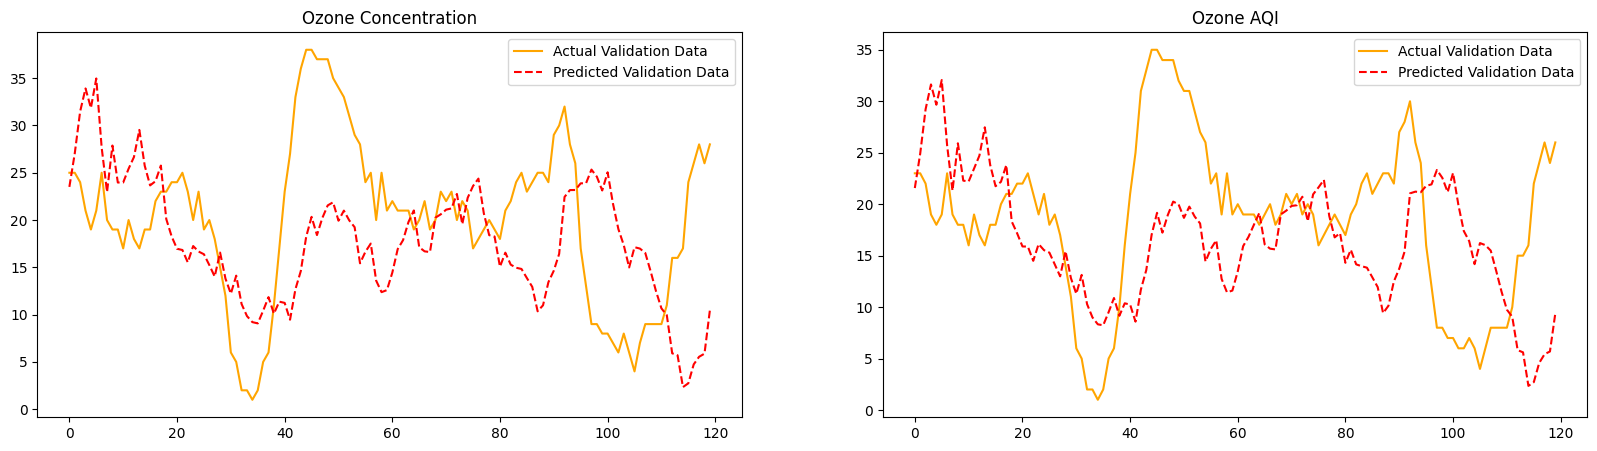

In [ ]:
rmse_ozone_conc, rmse_ozone_aqi, mean_forecast = VARMAX_function_ozone(5,1)

### Experiments for PM 2.5 Concentration and AQI

In [ ]:
feature_list = ["PM2.5_Concentration","PM2.5_AQI","pm10","carbon_monoxide", "wind_speed_10m","sulphur_dioxide"]

## 9 months of training + 5 days of validation ##
# Train on 9 months of data
X = df[feature_list].values
# Using the last 5 days (120 samples) as validation set
val_start_index = -5*24

# Split the dataset
train, val = X[:val_start_index,:], X[val_start_index:,:]

# Convert train to list for subsequent appending
history = train
preds = []

In [ ]:
def VARMAX_function_pm25(p, q):
  # Instantiate the model
  model = VARMAX(history, order=(p, q))

  # Fit the model
  results = model.fit(maxiter=1000, disp=False)

  # Generate predictions
  one_step_forecast = results.get_prediction(end=120)

  # Extract prediction mean
  mean_forecast = one_step_forecast.predicted_mean
  mean_forecast = mean_forecast[1:,:]

  rmse_pm25_conc = math.sqrt(mean_squared_error(val[:,0], mean_forecast[:,0]))
  print('PM2.5_Concentration Validation RMSE: %.3f' % rmse_pm25_conc)

  rmse_pm25_aqi = math.sqrt(mean_squared_error(val[:,1], mean_forecast[:,1]))
  print('PM2.5_AQI Validation RMSE: %.3f' % rmse_pm25_aqi)

  # Plotting the validation set and the predictions

  fig, axs = pyplot.subplots(1, 2, figsize=(20, 5))
  # First subplot for PM2.5 Concentration
  val_line1, = axs[0].plot(val[:,0], label='Actual Validation Data', color='orange')
  pred_line1, = axs[0].plot(mean_forecast[:,0], label='Predicted Validation Data', color='red', linestyle='--')
  axs[0].legend(handles=[val_line1, pred_line1])
  axs[0].set_title("PM2.5 Concentration")

  # Second subplot for PM2.5 AQI
  val_line2, = axs[1].plot(val[:,1], label='Actual Validation Data', color='orange')
  pred_line2, = axs[1].plot(mean_forecast[:,1], label='Predicted Validation Data', color='red', linestyle='--')
  axs[1].legend(handles=[val_line2, pred_line2])
  axs[1].set_title("PM2.5 AQI")

  # Display the plots
  pyplot.show()

  return rmse_pm25_conc, rmse_pm25_aqi, mean_forecast

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


PM2.5_Concentration Validation RMSE: 4.348
PM2.5_AQI Validation RMSE: 15.008


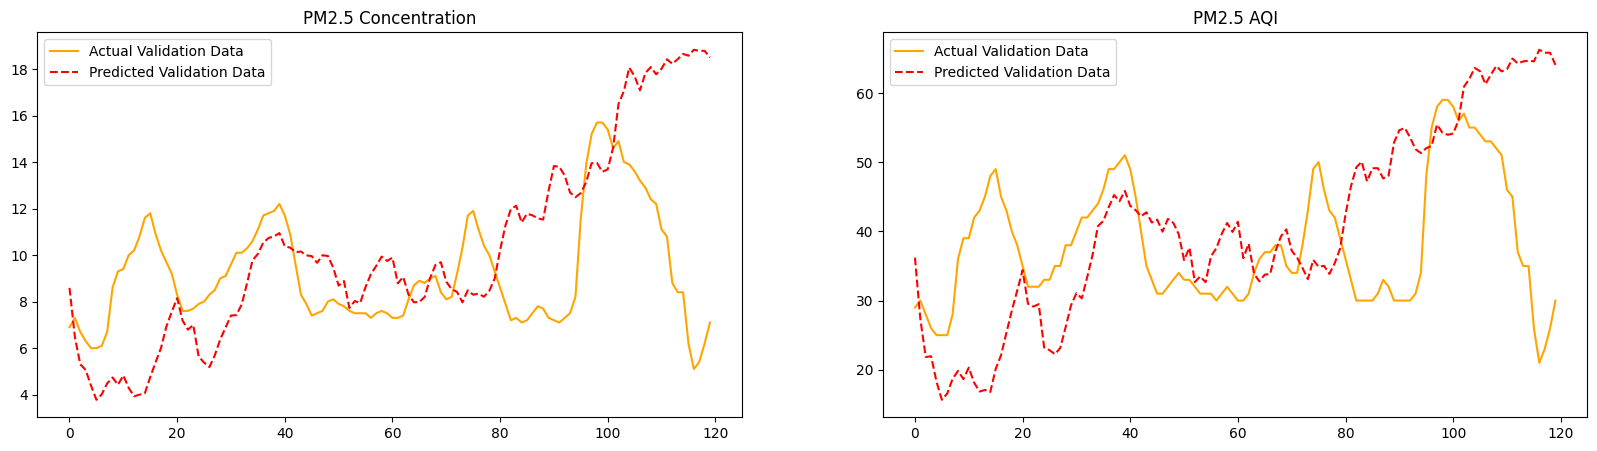

In [ ]:
rmse_pm25_conc, rmse_pm25_aqi, mean_forecast = VARMAX_function_pm25(5,1)

### All Variable Experiments


In [ ]:
feature_list = ["Ozone_Concentration","Ozone_AQI", "PM2.5_Concentration","PM2.5_AQI", "pm10","carbon_monoxide","nitrogen_dioxide","sulphur_dioxide",
                "temperature_2m","relative_humidity_2m","dew_point_2m","wind_speed_10m"]

## 9 months of training + 5 days of validation ##
# Train on 9 months of data
X = df[feature_list].values
# Using the last 5 days (120 samples) as validation set
val_start_index = -5*24

# Split the dataset
train, val = X[:val_start_index,:], X[val_start_index:,:]

# Convert train to list for subsequent appending
history = train

In [ ]:
def VARMAX_function(p, q):
  # Instantiate the model
  model = VARMAX(history, order=(p, q), enforce_stationarity=True, error_cov_type='diagonal')

  # Fit the model
  results = model.fit(maxiter=1000, disp=False)

  # Generate predictions
  one_step_forecast = results.get_prediction(end=120)

  # Extract prediction mean
  mean_forecast = one_step_forecast.predicted_mean

  mean_forecast = mean_forecast[1:,:]

  rmse_ozone_conc = math.sqrt(mean_squared_error(val[:,0], mean_forecast[:,0]))
  print('Ozone_Concentration Validation RMSE: %.3f' % rmse_ozone_conc)

  rmse_ozone_aqi = math.sqrt(mean_squared_error(val[:,1], mean_forecast[:,1]))
  print('Ozone_AQI Validation RMSE: %.3f' % rmse_ozone_aqi)

  rmse_pm25_conc = math.sqrt(mean_squared_error(val[:,2], mean_forecast[:,2]))
  print('PM2.5_Concentration Validation RMSE: %.3f' % rmse_pm25_conc)

  rmse_pm25_aqi = math.sqrt(mean_squared_error(val[:,3], mean_forecast[:,3]))
  print('PM2.5_AQI Validation RMSE: %.3f' % rmse_pm25_aqi)

  # Plotting the validation set and the predictions

  fig, axs = pyplot.subplots(2, 2, figsize=(20, 10))

  # First subplot for Ozone Concentration
  val_line1, = axs[0, 0].plot(val[:,0], label='Actual Validation Data', color='orange')
  pred_line1, = axs[0, 0].plot(mean_forecast[:,0], label='Predicted Validation Data', color='red', linestyle='--')
  axs[0, 0].legend(handles=[val_line1, pred_line1])
  axs[0, 0].set_title("Ozone Concentration")

  # Second subplot for Ozone AQI
  val_line2, = axs[0, 1].plot(val[:,1], label='Actual Validation Data', color='orange')
  pred_line2, = axs[0, 1].plot(mean_forecast[:,1], label='Predicted Validation Data', color='red', linestyle='--')
  axs[0, 1].legend(handles=[val_line2, pred_line2])
  axs[0, 1].set_title("Ozone AQI")

  # Third subplot for PM2.5 Concentration
  val_line3, = axs[1, 0].plot(val[:,2], label='Actual Validation Data', color='orange')
  pred_line3, = axs[1, 0].plot(mean_forecast[:,2], label='Predicted Validation Data', color='red', linestyle='--')
  axs[1, 0].legend(handles=[val_line3, pred_line3])
  axs[1, 0].set_title("PM2.5 Concentration")

  # Fourth subplot for PM2.5 AQI
  val_line4, = axs[1, 1].plot(val[:,3], label='Actual Validation Data', color='orange')
  pred_line4, = axs[1, 1].plot(mean_forecast[:,3], label='Predicted Validation Data', color='red', linestyle='--')
  axs[1, 1].legend(handles=[val_line4, pred_line4])
  axs[1, 1].set_title("PM2.5 AQI")

  # Adjust layout to prevent overlap
  pyplot.tight_layout()

  # Display the plots
  pyplot.show()

  return rmse_ozone_conc, rmse_ozone_aqi, rmse_pm25_conc, rmse_pm25_aqi, mean_forecast

Ozone_Concentration Validation RMSE: 10.363
Ozone_AQI Validation RMSE: 9.505
PM2.5_Concentration Validation RMSE: 4.372
PM2.5_AQI Validation RMSE: 15.095


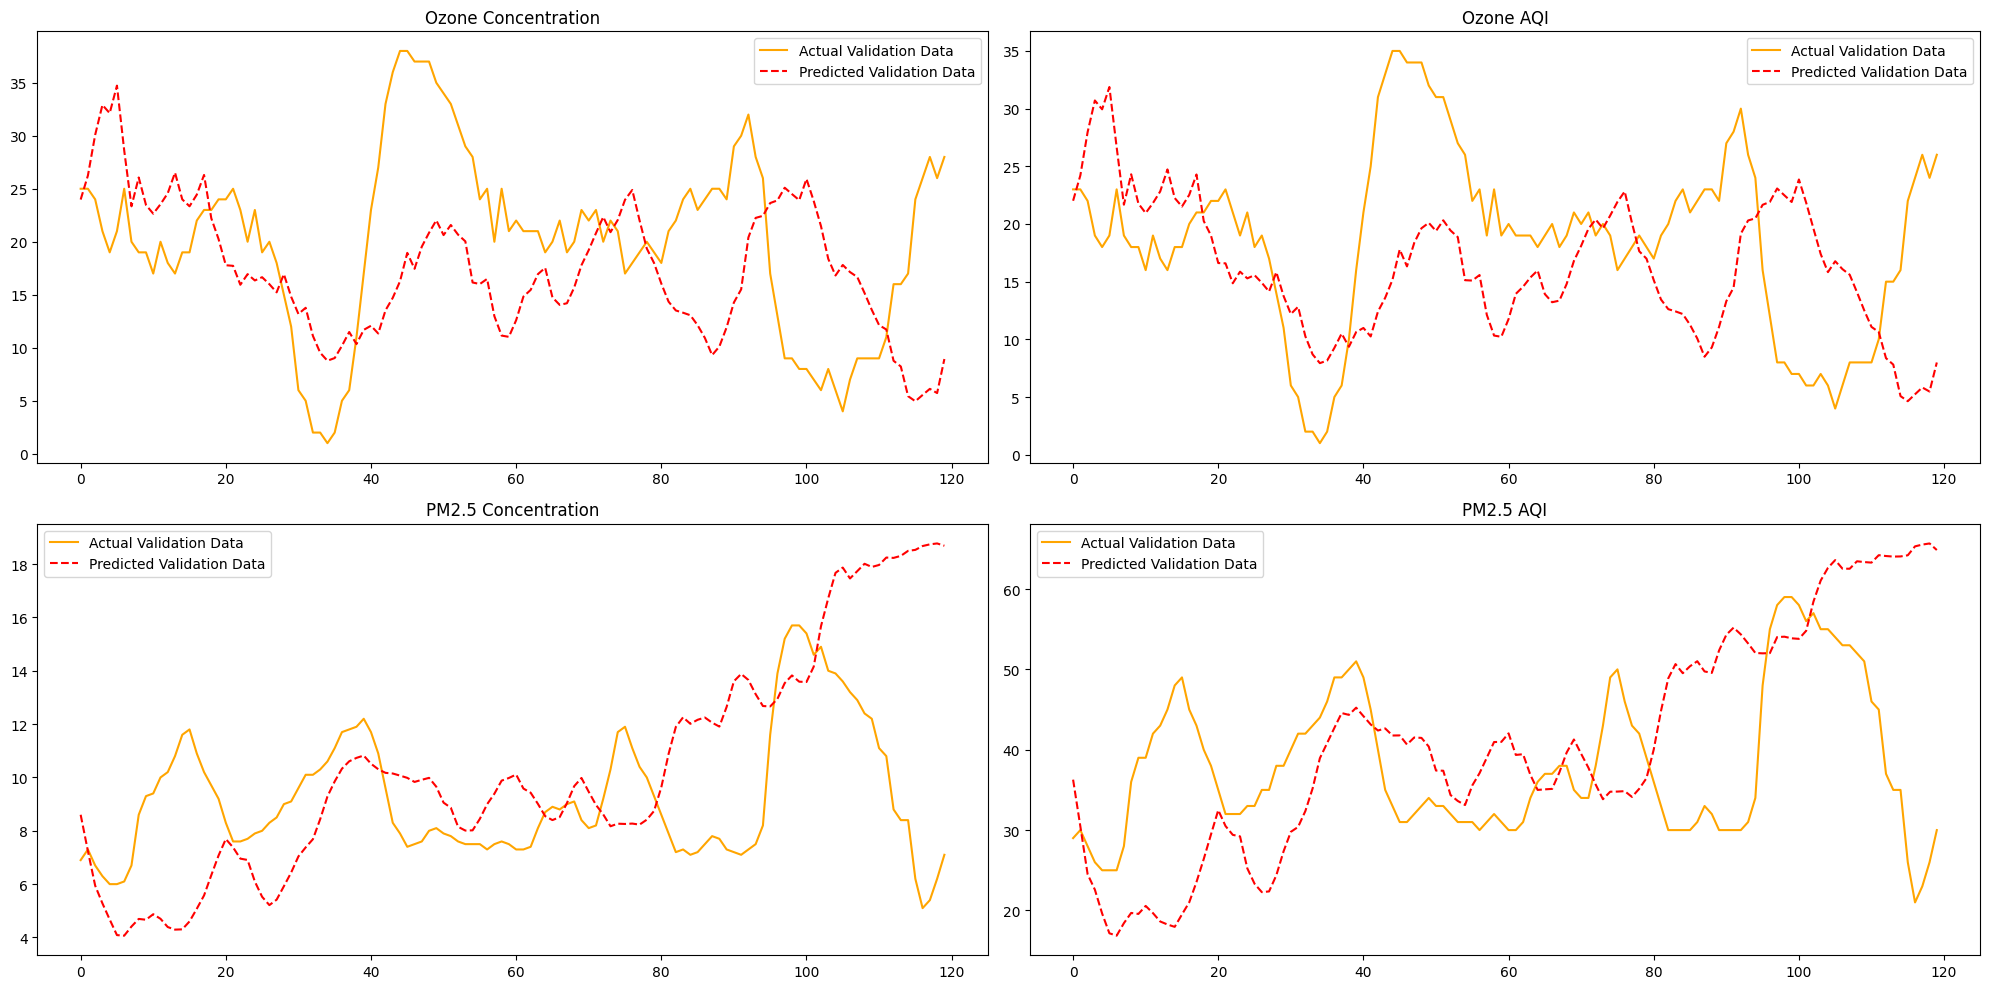

In [ ]:
rmse_ozone_conc, rmse_ozone_aqi, rmse_pm25_conc, rmse_pm25_aqi, mean_forecast = VARMAX_function(1,0)